In [103]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import random
import time

In [104]:
df = pd.read_pickle('newexport.pkl')
df = df.fillna(0)

In [105]:
# with help from http://planspace.org/20150423-forward_selection_with_statsmodels/
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < (best_new_score * 1):
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    
    model = smf.ols(formula, data).fit()
    return model

In [106]:
response=pd.read_pickle('ZipcodeMVPSnew.pkl')[['RegionName','2000_agg','2010_agg']]
response=response.rename(columns={'RegionName': 'zipcode'})
response['2010_agg_adj'] = response['2010_agg']/1.26
response['pct_delta'] = (response['2010_agg_adj']/response['2000_agg']) - 1
response = response.drop(['2010_agg','2000_agg', '2010_agg_adj'], 1)

In [107]:
response2=pd.read_pickle('ZipcodeMVPSnew.pkl')[['RegionName','2010_agg']]
response2=response2.rename(columns={'RegionName': 'zipcode','2010_agg':'agg2010'})

In [108]:
zipCodeStrings = df.zipcode
all_features = df.astype('float')

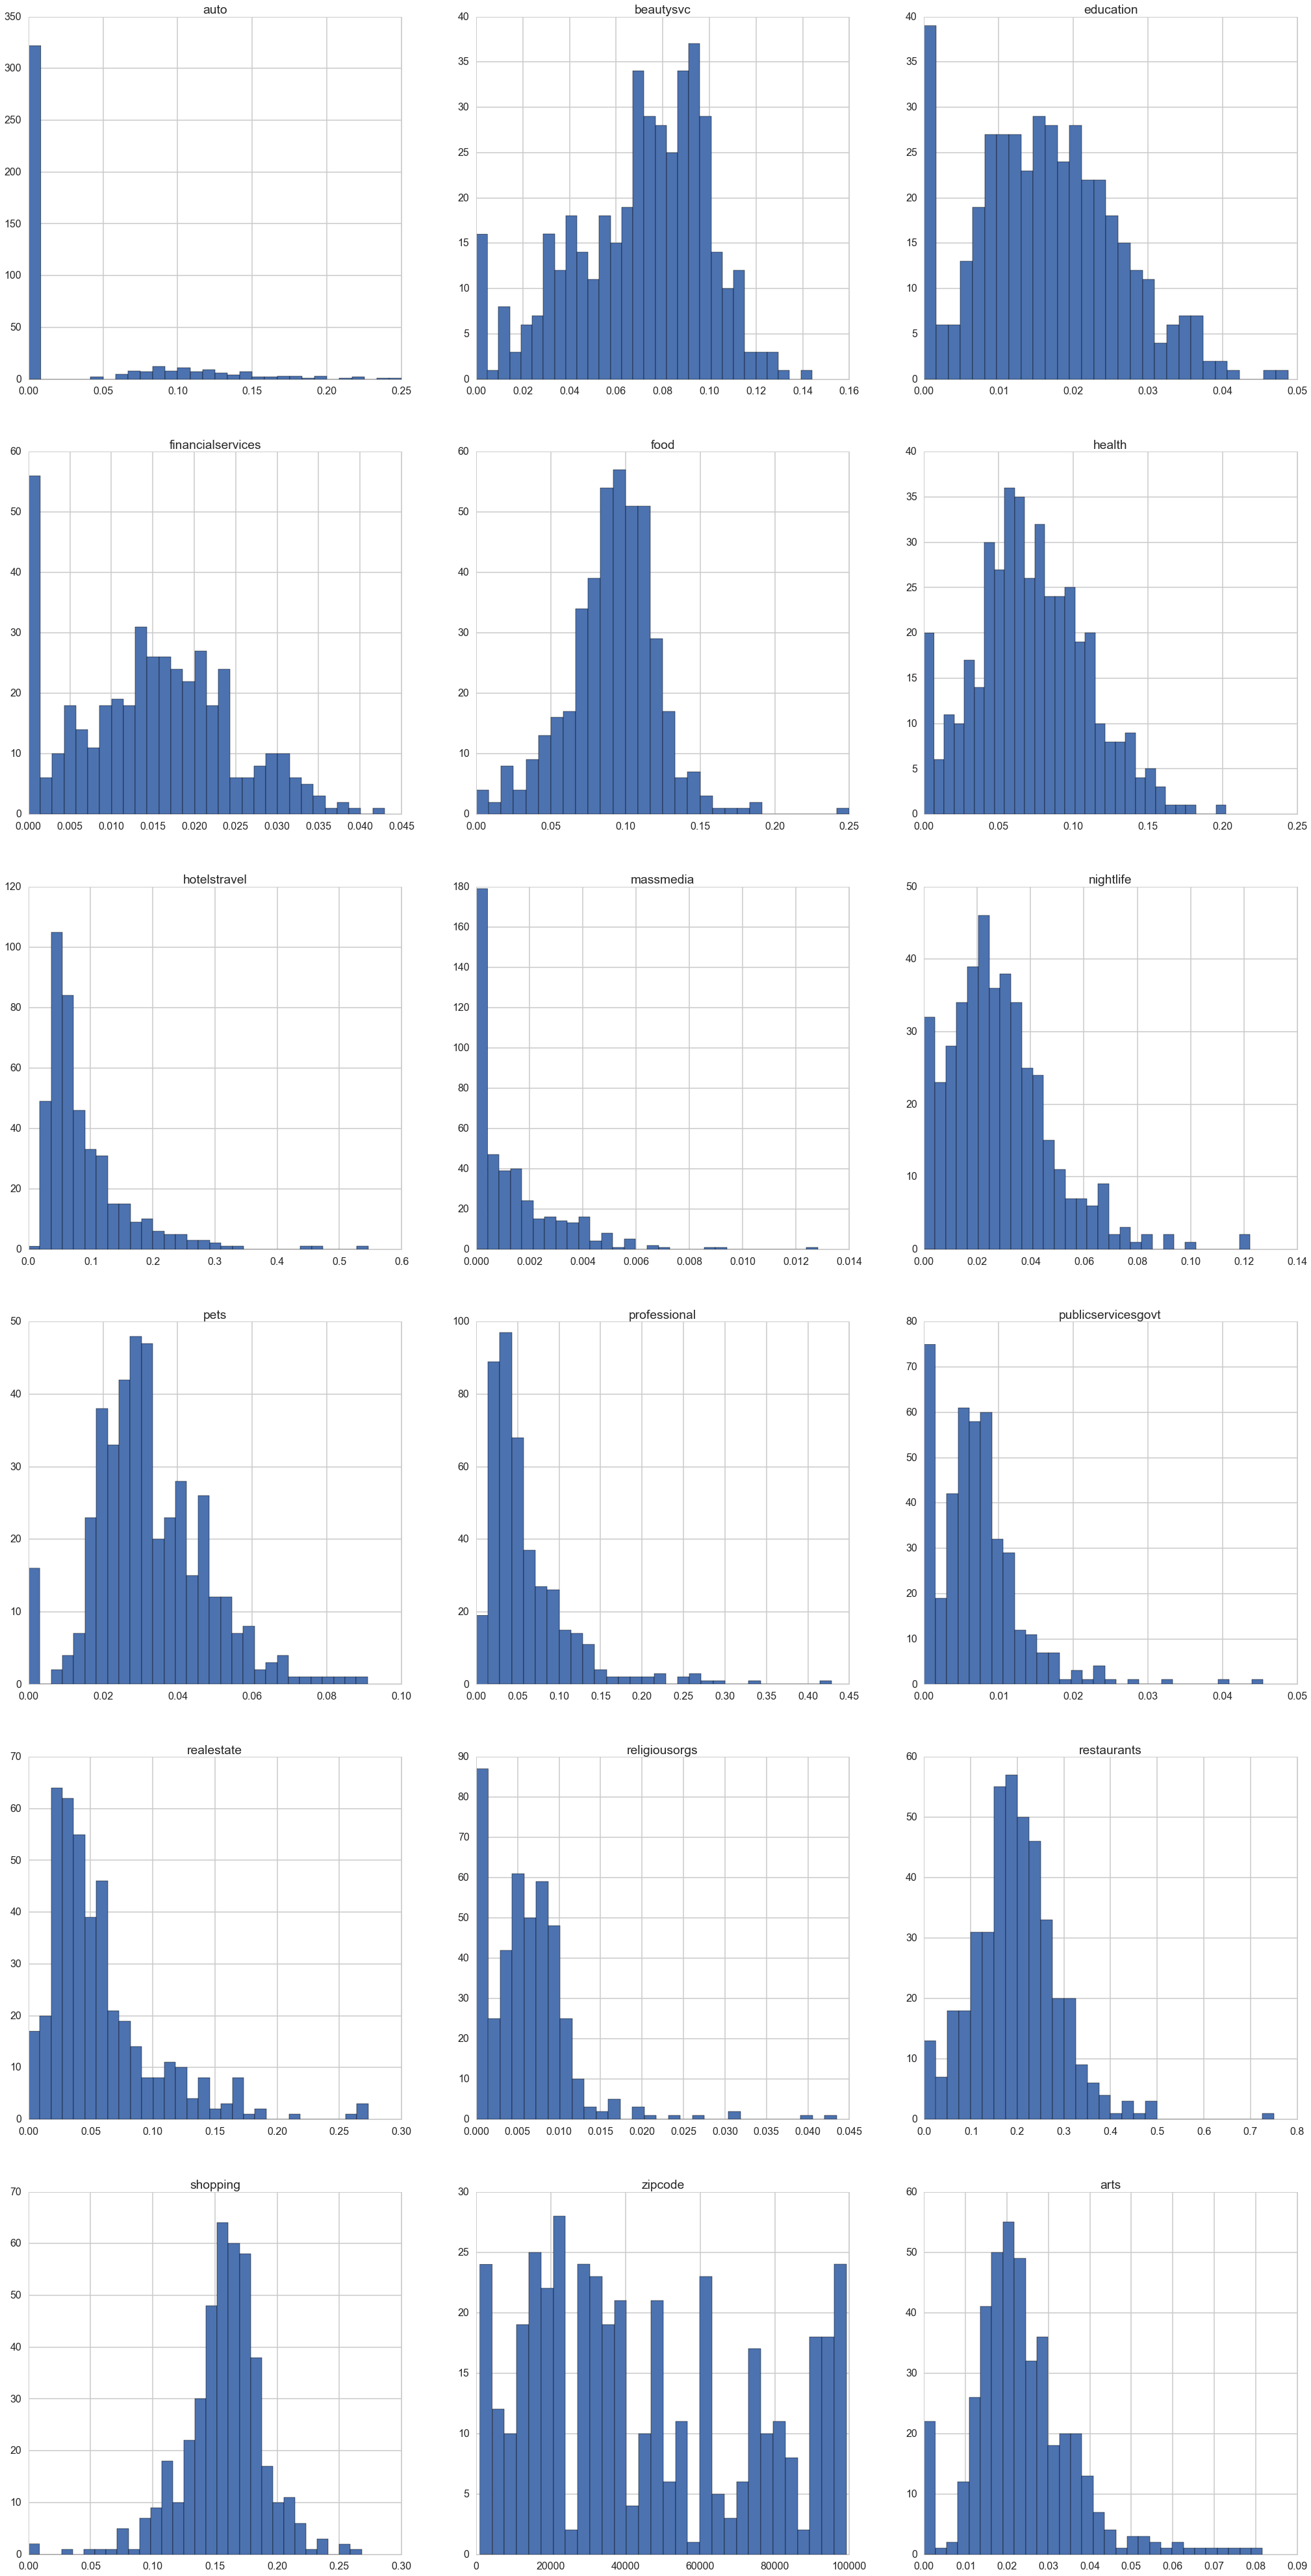

In [109]:
features = all_features.columns[1:]
if len(features)%3 == 0 :
    nROW = len(features)/3
else :
    nROW = np.ceil(len(features)/3.).astype(int)
nCOL = 3

f, ax = plt.subplots(nrows=nROW, ncols=nCOL, figsize=(35,70))

for i in xrange(len(features)):
    plt.subplot(nROW,nCOL,i)
    ax = all_features[features[i]].hist(bins = 30)
    ax.set_title(features[i])

In [110]:
merged = pd.merge(df, response2, on='zipcode')
merged = merged.astype('float')
merged = merged.drop('zipcode',1)

In [111]:
bestmodel = forward_selected(merged, u'agg2010')
bestmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                agg2010   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     21.99
Date:                Tue, 08 Dec 2015   Prob (F-statistic):           1.05e-39
Time:                        16:21:19   Log-Likelihood:                -2324.9
No. Observations:                 427   AIC:                             4678.
Df Residuals:                     413   BIC:                             4735.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            -18.8371     31.060     -0.606      0.545       -79.892    42.218
education           2363.3886    414.951      5.696      0.000      1547.710  3179.067
health               612.2961    140.215      4.367      0.000       336.673   887.920
restaurants          -71.6924     53.126     -1.349      0.178      -176.123    32.738
arts                 886.9584    245.318      3.616      0.000       404.731  1369.186
active               472.0239    129.180      3.654      0.000       218.092   725.956
nightlife           -486.4438    176.377     -2.758      0.006      -833.153  -139.735
food                 301.2674    120.135      2.508      0.013        65.115   537.420
religiousorgs      -1213.8807    588.229     -2.064      0.040     -2370.176   -57.585
publicservicesgovt  1104.3399    536.071      2.060      0.040        50.572  2158.108
financialservices   -734.7029    446.131     -1.647      0.100     -1611.674   142.268
auto                 127.1350     63.193      2.012      0.045         2.916   251.354
beautysvc            281.9315    156.810      1.798      0.073       -26.313   590.176
hotelstravel          88.3877     79.054      1.118      0.264       -67.011   243.787
==============================================================================
Omnibus:                      126.454   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.392
Skew:                           1.359   Prob(JB):                     5.10e-87
Kurtosis:                       6.866   Cond. No.                         232.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
merged.columns

Index([u'active', u'arts', u'auto', u'beautysvc', u'education', u'financialservices', u'food', u'health', u'hotelstravel', u'massmedia', u'nightlife', u'pets', u'professional', u'publicservicesgovt', u'realestate', u'religiousorgs', u'restaurants', u'shopping', u'agg2010'], dtype='object')